# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [2]:
!pip install torch

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/16/dd/1bf10180ba812afa1aa7427466083d731bc37b9a1157ec929d0cfeef87eb/torch-2.1.0-cp311-none-macosx_10_9_x86_64.whl.metadata
  Using cached torch-2.1.0-cp311-none-macosx_10_9_x86_64.whl.metadata (24 kB)
Using cached torch-2.1.0-cp311-none-macosx_10_9_x86_64.whl (146.7 MB)


In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import MLP_hidden, CustomDataset, train_loop, test_loop, intialise_loaders

3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [3]:
es_patience = 3
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    
    # YOUR CODE HERE
    train_dataloader, val_dataloader = intialise_loaders(X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    loss_fn = nn.BCELoss()
    earlyStop = EarlyStopper(patience = es_patience)
    for t in range(epochs):
        start_time = time.time()
        train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
        end_time = time.time()
        validation_loss, validation_correct = test_loop(val_dataloader, model, loss_fn)   
        print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*validation_correct):>0.2f}%, Test_loss: {validation_loss:>8f}")
        print("\n")
        elapsed_time = end_time - start_time # Time spent in training the last epoch of an experiment.
        if earlyStop.early_stop(validation_loss): 
            print("Done!")
            print("\n")
            break


    return train_correct, train_loss, validation_correct, validation_loss, elapsed_time

In [4]:
from common_utils import split_dataset, preprocess_dataset

def preprocess(df):
    # Preporocessing
    f_columns_to_drop = ['label', 'filename'] # These columns are dropped to get only the features
    X_train_notscaled, y_train, X_test_notscaled, y_test = split_dataset(df, columns_to_drop = f_columns_to_drop, test_size = 0.3, random_state = 0)
    return X_train_notscaled, y_train, X_test_notscaled, y_test


df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()
X_train_notscaled, y_train, X_test_notscaled, y_test = preprocess(df)


In [5]:
from common_utils import EarlyStopper
model_no_features = 77
model_no_hidden = 128
model_no_labels = 1
optimal_bs = 128
learning_rate = 0.001
epochs = 50
no_folds = 5

In [6]:
from common_utils import preprocess_dataset
def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):
    # YOUR CODE HERE
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = {}, {}, {}, {}
    cv = KFold(n_splits = no_folds, shuffle=True, random_state=1)
    fold = 0
    for train_idx, test_idx in cv.split(X_train, y_train):
        x_train, y_train_1  = X_train[train_idx], y_train[train_idx]
        x_test, y_test = X_train[test_idx], y_train[test_idx]
        X_train_scaled, X_test_scaled = preprocess_dataset(x_train, x_test)
            
        X_train_scaled_dict[fold] = X_train_scaled
        X_val_scaled_dict[fold] = X_test_scaled
        y_train_dict[fold]= y_train_1
        y_val_dict[fold]= y_test
        fold += 1

    cross_validation_accuracies= {}
    cross_validation_times = {}

    for neuron in parameters:
        print(neuron)
        print("----------------------------------")
        print("\n")
        
        list_neuron_time = [] # Temporarily stores the time taken to train the last epoch after each experiment
        list_neuron_val_accuracies = [] # Temporarily stores the test accuracies on last epoch after each experiment
        
        for experiment in range(len(X_train_scaled_dict)):
            print(f"Experiment {experiment+1}")
            X_train_batch = X_train_scaled_dict[experiment]
            X_val_batch = X_val_scaled_dict[experiment]
            y_train_batch = y_train_dict[experiment]
            y_val_batch = y_val_dict[experiment]
            
            model_1 = MLP_hidden(no_features = model_no_features, no_hidden = model_no_hidden, no_labels = model_no_labels, no_neuron = neuron)
            train_accuracies, train_losses, val_accuracies, val_losses, times = train(model = model_1, X_train_scaled = X_train_batch, y_train2 = y_train_batch, X_val_scaled = X_val_batch, y_val2 = y_val_batch, batch_size = batch_size)
            list_neuron_val_accuracies.append(val_accuracies)
            list_neuron_time.append(times)

        # print(len(list_neuron_val_accuracies)) Debugging
        
        average_time_lepoch = np.mean(list_neuron_time)
        
        #average_time_lepoch = "{:.2}".format(average_time_lepoch_1)

        average_classification_accuracy = np.mean(list_neuron_val_accuracies)
        
        #average_classification_accuracy = "{:.2f}".format(average_classification_accuracy_1)
        
        # print(average_classification_error) Debugging
        
        cross_validation_accuracies[neuron] = average_classification_accuracy
        cross_validation_times[neuron] = average_time_lepoch
    
    return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 128. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE
num_neurons = [64, 128, 256]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_notscaled.to_numpy(), y_train, num_neurons, 'num_neurons', optimal_bs)

64
----------------------------------


Experiment 1
loss: 0.697959  [  128/ 6751]
Train Error: 
 Accuracy: 52.8%, Avg loss: 0.689726 

Test Error: 
 Accuracy: 55.9%, Avg loss: 0.684657 

Epoch 1: Train_accuracy: 52.82%, Train_loss: 0.689726, Test_accuracy: 55.86%, Test_loss: 0.684657


loss: 0.689205  [  128/ 6751]
Train Error: 
 Accuracy: 56.7%, Avg loss: 0.676510 

Test Error: 
 Accuracy: 58.1%, Avg loss: 0.671536 

Epoch 2: Train_accuracy: 56.69%, Train_loss: 0.676510, Test_accuracy: 58.06%, Test_loss: 0.671536


loss: 0.635422  [  128/ 6751]
Train Error: 
 Accuracy: 59.4%, Avg loss: 0.667481 

Test Error: 
 Accuracy: 59.4%, Avg loss: 0.663997 

Epoch 3: Train_accuracy: 59.35%, Train_loss: 0.667481, Test_accuracy: 59.42%, Test_loss: 0.663997


loss: 0.642221  [  128/ 6751]
Train Error: 
 Accuracy: 61.3%, Avg loss: 0.655752 

Test Error: 
 Accuracy: 60.2%, Avg loss: 0.660479 

Epoch 4: Train_accuracy: 61.31%, Train_loss: 0.655752, Test_accuracy: 60.19%, Test_loss: 0.660479


loss: 0

Train Error: 
 Accuracy: 63.8%, Avg loss: 0.637710 

Test Error: 
 Accuracy: 59.8%, Avg loss: 0.665742 

Epoch 5: Train_accuracy: 63.84%, Train_loss: 0.637710, Test_accuracy: 59.83%, Test_loss: 0.665742


loss: 0.602411  [  128/ 6751]
Train Error: 
 Accuracy: 65.2%, Avg loss: 0.622196 

Test Error: 
 Accuracy: 62.1%, Avg loss: 0.659801 

Epoch 6: Train_accuracy: 65.25%, Train_loss: 0.622196, Test_accuracy: 62.09%, Test_loss: 0.659801


loss: 0.653873  [  128/ 6751]
Train Error: 
 Accuracy: 65.3%, Avg loss: 0.618017 

Test Error: 
 Accuracy: 63.4%, Avg loss: 0.641372 

Epoch 7: Train_accuracy: 65.26%, Train_loss: 0.618017, Test_accuracy: 63.45%, Test_loss: 0.641372


loss: 0.576197  [  128/ 6751]
Train Error: 
 Accuracy: 67.3%, Avg loss: 0.602283 

Test Error: 
 Accuracy: 62.3%, Avg loss: 0.655304 

Epoch 8: Train_accuracy: 67.28%, Train_loss: 0.602283, Test_accuracy: 62.32%, Test_loss: 0.655304


loss: 0.562799  [  128/ 6751]
Train Error: 
 Accuracy: 67.9%, Avg loss: 0.593384 

Test Er

Train Error: 
 Accuracy: 71.4%, Avg loss: 0.555554 

Test Error: 
 Accuracy: 63.7%, Avg loss: 0.637823 

Epoch 13: Train_accuracy: 71.43%, Train_loss: 0.555554, Test_accuracy: 63.66%, Test_loss: 0.637823


loss: 0.533000  [  128/ 6752]
Train Error: 
 Accuracy: 72.0%, Avg loss: 0.545868 

Test Error: 
 Accuracy: 63.5%, Avg loss: 0.636033 

Epoch 14: Train_accuracy: 72.02%, Train_loss: 0.545868, Test_accuracy: 63.54%, Test_loss: 0.636033


loss: 0.441991  [  128/ 6752]
Train Error: 
 Accuracy: 72.5%, Avg loss: 0.534951 

Test Error: 
 Accuracy: 65.2%, Avg loss: 0.648141 

Epoch 15: Train_accuracy: 72.53%, Train_loss: 0.534951, Test_accuracy: 65.20%, Test_loss: 0.648141


loss: 0.470478  [  128/ 6752]
Train Error: 
 Accuracy: 73.5%, Avg loss: 0.529970 

Test Error: 
 Accuracy: 65.5%, Avg loss: 0.639390 

Epoch 16: Train_accuracy: 73.50%, Train_loss: 0.529970, Test_accuracy: 65.50%, Test_loss: 0.639390


loss: 0.541433  [  128/ 6752]
Train Error: 
 Accuracy: 74.2%, Avg loss: 0.520889 

Tes

Train Error: 
 Accuracy: 63.9%, Avg loss: 0.630147 

Test Error: 
 Accuracy: 61.8%, Avg loss: 0.655742 

Epoch 5: Train_accuracy: 63.87%, Train_loss: 0.630147, Test_accuracy: 61.85%, Test_loss: 0.655742


loss: 0.629211  [  128/ 6751]
Train Error: 
 Accuracy: 66.3%, Avg loss: 0.611503 

Test Error: 
 Accuracy: 62.0%, Avg loss: 0.662284 

Epoch 6: Train_accuracy: 66.35%, Train_loss: 0.611503, Test_accuracy: 61.97%, Test_loss: 0.662284


loss: 0.569857  [  128/ 6751]
Train Error: 
 Accuracy: 67.4%, Avg loss: 0.599520 

Test Error: 
 Accuracy: 63.3%, Avg loss: 0.649443 

Epoch 7: Train_accuracy: 67.35%, Train_loss: 0.599520, Test_accuracy: 63.27%, Test_loss: 0.649443


loss: 0.600748  [  128/ 6751]
Train Error: 
 Accuracy: 68.8%, Avg loss: 0.583520 

Test Error: 
 Accuracy: 64.1%, Avg loss: 0.633824 

Epoch 8: Train_accuracy: 68.76%, Train_loss: 0.583520, Test_accuracy: 64.10%, Test_loss: 0.633824


loss: 0.615229  [  128/ 6751]
Train Error: 
 Accuracy: 70.8%, Avg loss: 0.565588 

Test Er

Train Error: 
 Accuracy: 61.7%, Avg loss: 0.651595 

Test Error: 
 Accuracy: 59.8%, Avg loss: 0.654384 

Epoch 3: Train_accuracy: 61.66%, Train_loss: 0.651595, Test_accuracy: 59.83%, Test_loss: 0.654384


loss: 0.628941  [  128/ 6751]
Train Error: 
 Accuracy: 64.2%, Avg loss: 0.630383 

Test Error: 
 Accuracy: 63.3%, Avg loss: 0.654141 

Epoch 4: Train_accuracy: 64.24%, Train_loss: 0.630383, Test_accuracy: 63.27%, Test_loss: 0.654141


loss: 0.659444  [  128/ 6751]
Train Error: 
 Accuracy: 65.9%, Avg loss: 0.612568 

Test Error: 
 Accuracy: 62.1%, Avg loss: 0.650825 

Epoch 5: Train_accuracy: 65.89%, Train_loss: 0.612568, Test_accuracy: 62.09%, Test_loss: 0.650825


loss: 0.656995  [  128/ 6751]
Train Error: 
 Accuracy: 68.0%, Avg loss: 0.590972 

Test Error: 
 Accuracy: 63.3%, Avg loss: 0.639507 

Epoch 6: Train_accuracy: 67.96%, Train_loss: 0.590972, Test_accuracy: 63.33%, Test_loss: 0.639507


loss: 0.563941  [  128/ 6751]
Train Error: 
 Accuracy: 70.0%, Avg loss: 0.568459 

Test Er

Train Error: 
 Accuracy: 74.0%, Avg loss: 0.521721 

Test Error: 
 Accuracy: 68.3%, Avg loss: 0.594481 

Epoch 9: Train_accuracy: 73.96%, Train_loss: 0.521721, Test_accuracy: 68.31%, Test_loss: 0.594481


loss: 0.546400  [  128/ 6751]
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.505126 

Test Error: 
 Accuracy: 67.1%, Avg loss: 0.656771 

Epoch 10: Train_accuracy: 74.61%, Train_loss: 0.505126, Test_accuracy: 67.12%, Test_loss: 0.656771


loss: 0.478778  [  128/ 6751]
Train Error: 
 Accuracy: 76.4%, Avg loss: 0.484940 

Test Error: 
 Accuracy: 69.4%, Avg loss: 0.602270 

Epoch 11: Train_accuracy: 76.37%, Train_loss: 0.484940, Test_accuracy: 69.43%, Test_loss: 0.602270


loss: 0.446635  [  128/ 6751]
Train Error: 
 Accuracy: 77.8%, Avg loss: 0.462502 

Test Error: 
 Accuracy: 69.1%, Avg loss: 0.645975 

Epoch 12: Train_accuracy: 77.75%, Train_loss: 0.462502, Test_accuracy: 69.14%, Test_loss: 0.645975


Done!


Experiment 5
loss: 0.695036  [  128/ 6752]
Train Error: 
 Accuracy: 54.5%, Avg 

In [7]:
print(cross_validation_accuracies)
print(cross_validation_times)
accuracy_keys_list = list(cross_validation_accuracies.keys())
accuracy_values_list = list(cross_validation_accuracies.values())
times_keys_list = list(cross_validation_times.keys())
times_values_list = list(cross_validation_times.values())

{64: 0.6583727809819725, 128: 0.6552872257042284, 256: 0.6688009366299863}
{64: 0.12389583587646484, 128: 0.14236764907836913, 256: 0.1632551670074463}


4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

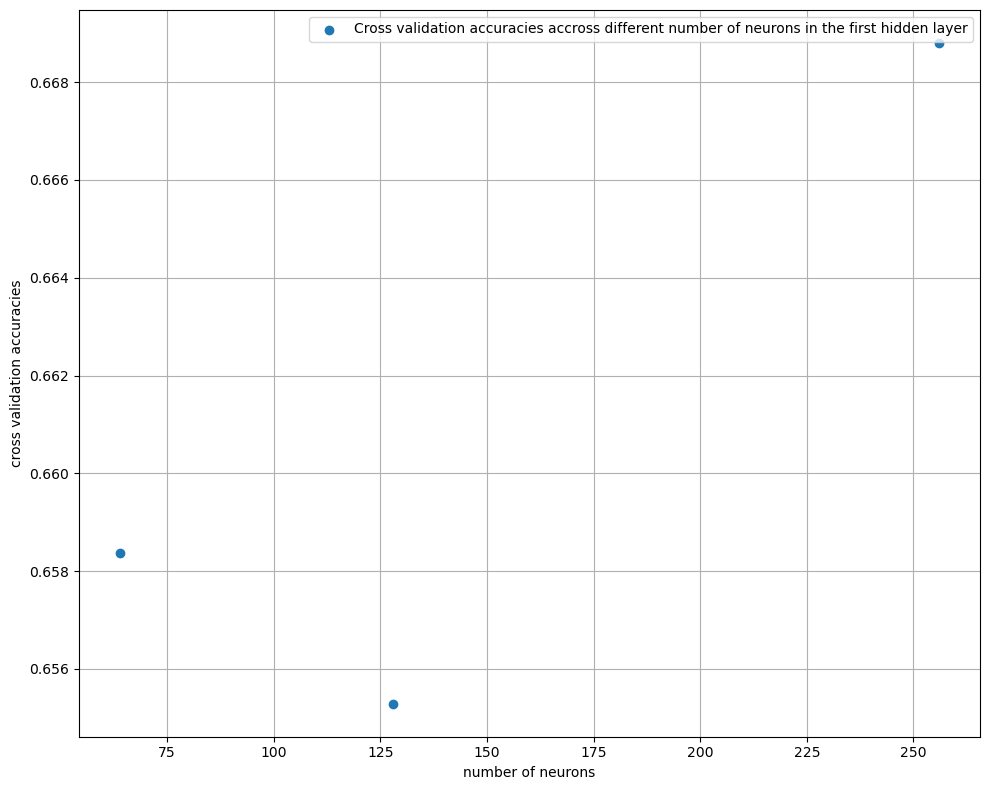

In [8]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.scatter(accuracy_keys_list,accuracy_values_list, label='Cross validation accuracies accross different number of neurons in the first hidden layer')


plt.xlabel('number of neurons')
plt.ylabel('cross validation accuracies')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

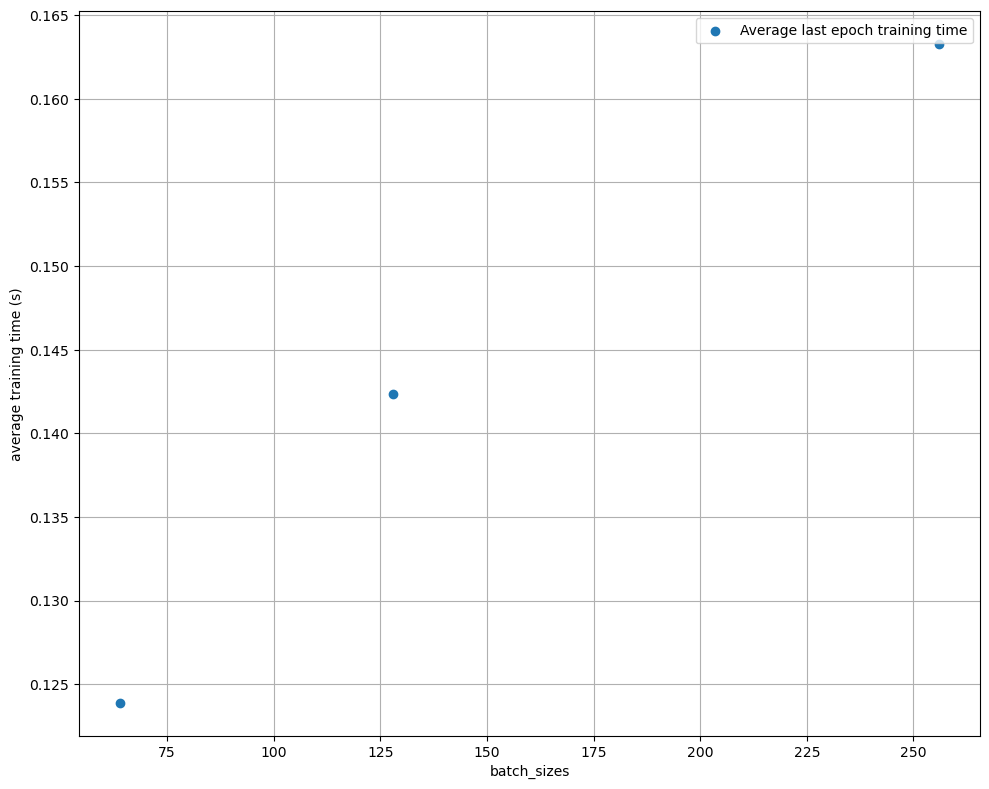

In [9]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.scatter(times_keys_list,times_values_list, label='Average last epoch training time')


plt.xlabel('batch_sizes')
plt.ylabel('average training time (s)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [11]:
optimal_neurons = 256
reason = "The model trained with the first hidden layer having 256 neurons has the highest mean cross validation accuracy. At the same time, training the model with more neurons in the first hidden layer also takes more time as demostrated by the chart but it is expected and also cause the difference isn't very significant we can choose the model trained with 256 neurons."


6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

In [13]:
neuron = 256
model_final = MLP_hidden(no_features = model_no_features, no_hidden = model_no_hidden, no_labels = model_no_labels, no_neuron = neuron)
optimizer_final = torch.optim.Adam(model_final.parameters(), lr = learning_rate)
loss_fn_final = nn.BCELoss()
X_train_scaled, X_test_scaled = preprocess_dataset(X_train_notscaled, X_test_notscaled)

batch_size = 128
train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test, batch_size)
earlyStop = EarlyStopper(patience = es_patience)

tr_loss, tr_correct = [], []
te_loss, te_correct = [], []

for t in range(epochs):
    train_loss, train_correct = train_loop(train_dataloader, model_final, loss_fn_final, optimizer_final)
    test_loss, test_correct = test_loop(test_dataloader, model_final, loss_fn_final)
    
    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if earlyStop.early_stop(test_loss): 
        print("Done!")
        break

loss: 0.693162  [  128/ 8439]
Train Error: 
 Accuracy: 55.6%, Avg loss: 0.684485 

Test Error: 
 Accuracy: 57.8%, Avg loss: 0.676439 

Epoch 1: Train_accuracy: 55.65%, Train_loss: 0.684485, Test_accuracy: 57.85%, Test_loss: 0.676439
loss: 0.647114  [  128/ 8439]
Train Error: 
 Accuracy: 59.0%, Avg loss: 0.664676 

Test Error: 
 Accuracy: 58.3%, Avg loss: 0.667805 

Epoch 2: Train_accuracy: 58.99%, Train_loss: 0.664676, Test_accuracy: 58.26%, Test_loss: 0.667805
loss: 0.675017  [  128/ 8439]
Train Error: 
 Accuracy: 62.0%, Avg loss: 0.646761 

Test Error: 
 Accuracy: 60.1%, Avg loss: 0.658146 

Epoch 3: Train_accuracy: 62.02%, Train_loss: 0.646761, Test_accuracy: 60.09%, Test_loss: 0.658146
loss: 0.598209  [  128/ 8439]
Train Error: 
 Accuracy: 65.4%, Avg loss: 0.623696 

Test Error: 
 Accuracy: 63.5%, Avg loss: 0.639563 

Epoch 4: Train_accuracy: 65.43%, Train_loss: 0.623696, Test_accuracy: 63.54%, Test_loss: 0.639563
loss: 0.592044  [  128/ 8439]
Train Error: 
 Accuracy: 67.1%, Avg lo

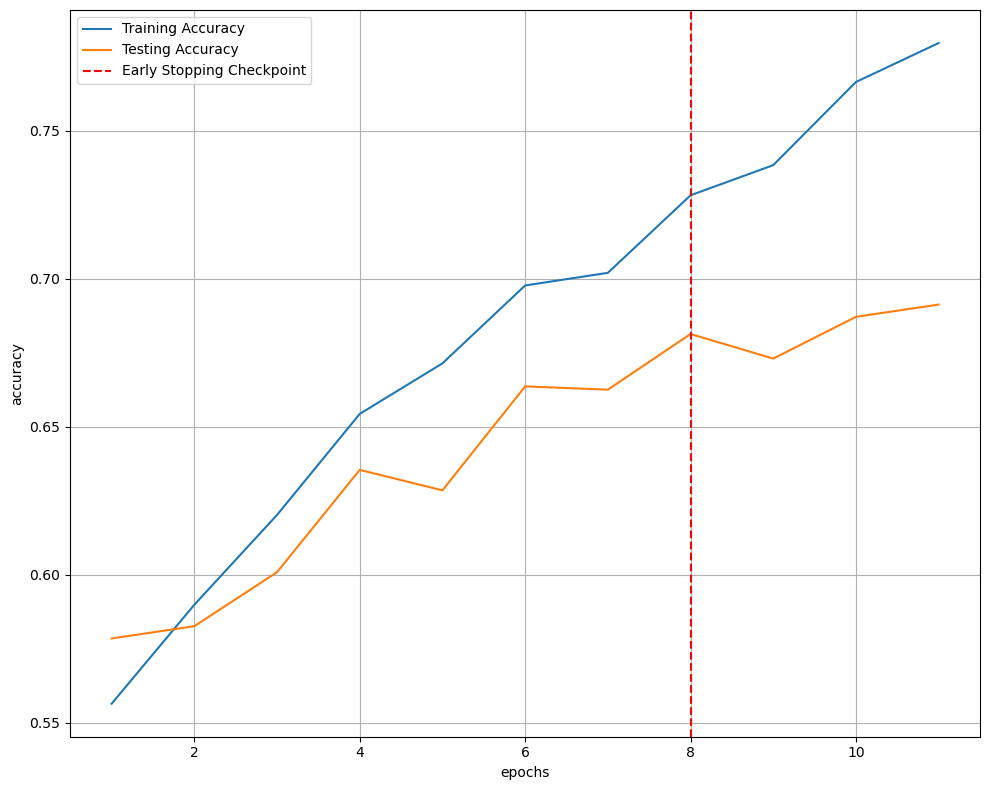

In [14]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr_correct)+1),tr_correct, label='Training Accuracy')
plt.plot(range(1,len(te_correct)+1),te_correct,label='Testing Accuracy')

# find position of lowest validation loss
minposs = te_loss.index(min(te_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()